In [5]:
from MicFileTool import MicFile
a=MicFile('/home/yufengs/workspace/Reconstructions/Ti7_WithHRM_2ndLoad_z1_.mic.LBFS')

-0.556875 -0.00974279 0 2 7 1 281.746 88.7135 78.1765 0.145161 0.885753 0.14876 0 1 1 1 0 0 0

<class 'str'>
sw is 0.72 

shape of snp is (32855, 19)


In [22]:
xy=a.snp[:,:2]
phi1=a.snp[:,6]
psi=a.snp[:,7]
phi2=a.snp[:,8]
conf=a.snp[:,9]

In [34]:
gridX=np.arange(np.min(xy[:,0]),np.max(xy[:,0]),0.005)
gridY=np.arange(np.min(xy[:,1]),np.max(xy[:,1]),0.005)
xv,yv=np.meshgrid(gridX,gridY)
SqXY=np.hstack([xv.reshape((-1,1)),yv.reshape((-1,1))])
print(SqXY.shape)

(30744, 2)


In [18]:
import scipy.interpolate

In [36]:
ConfF=scipy.interpolate.griddata(xy, conf, SqXY, method='linear', rescale=False)

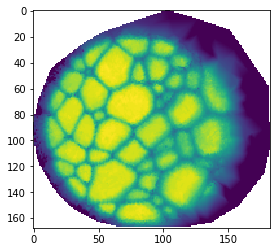

In [43]:
plt.imshow(np.flipud(ConfF.reshape((len(gridY),len(gridX)))))
plt.show()

In [32]:
a.snp[23]

array([-5.51250e-01,  9.74279e-03,  0.00000e+00,  2.00000e+00,
        7.00000e+00,  0.00000e+00,  2.81925e+02,  8.75878e+01,
        7.77789e+01,  0.00000e+00,  9.14062e-01,  0.00000e+00,
        0.00000e+00,  1.00000e+00,  1.00000e+00,  1.00000e+00,
        0.00000e+00,  0.00000e+00,  0.00000e+00])

# plot simulated peaks

In [1]:
import pycuda.gpuarray as gpuarray
from pycuda.autoinit import context
import pycuda.driver as cuda
import pycuda.autoinit
import numpy as np

In [2]:
import numpy as np
x15=np.load('/home/yufengs/Strain/Results/g15_2nd/x.npy')
y15=np.load('/home/yufengs/Strain/Results/g15_2nd/y.npy')
S15=np.load('/home/yufengs/Strain/Results/g15_2nd/allMaxS.npy')

In [3]:
Im=[]
for ii in range(96):
    Im.append(np.load('/home/yufengs/Strain/g15Ps1_2nd_filtered/Im{0:d}.npy'.format(ii)))
Lim=[]
for ii in range(96):
    Lim.append(np.load('/home/yufengs/Strain/g15Ps1_2nd_bf/limit{0:d}.npy'.format(ii)))

In [4]:
from InitStrain import Initializer
from Reconst_GPU import StrainReconstructor_GPU
Cfg=Initializer('/home/yufengs/StrainRecon/ConfigFiles/g15Ps1_2nd.yml')
Cfg.Simulate()
recon=StrainReconstructor_GPU( _NumG=Cfg.NumG,
        bfPath=Cfg.bfPath,
        fltPath=Cfg.fltPath,
        maxIntfn=Cfg.maxIntfn,
        _Det=Cfg.Det, _Gs=Cfg.Gs, _Info=Cfg.Info, _eng=Cfg.eng)
recon.loadGs()

In [5]:
NumD=len(x15)

S15D=gpuarray.to_gpu(S15.ravel().astype(np.float32))

XD=gpuarray.empty(96*NumD,dtype=np.int32)
YD=gpuarray.empty(96*NumD,dtype=np.int32)
OffsetD=gpuarray.empty(96*NumD,dtype=np.int32)

MaskD=gpuarray.empty(96*NumD,dtype=np.bool_)
TrueMaskD=gpuarray.empty(96*NumD,dtype=np.bool_)

x15D=gpuarray.to_gpu(x15.astype(np.float32))
y15D=gpuarray.to_gpu(y15.astype(np.float32))

In [6]:
recon.sim_grain(XD,YD,OffsetD,MaskD,TrueMaskD,
                    x15D, y15D,recon.afDetInfoD,S15D,
                    recon.whichOmegaD,np.int32(NumD),np.int32(96),np.float32(recon.eng),np.int32(45),recon.LimD,np.int32(5),
                     block=(recon.NumG,1,1),grid=(NumD,1))

In [38]:
recon.loadIm()

In [39]:
BlockSize=256
scoreD=gpuarray.empty(NumD,dtype=np.float32)
recon.hit_func(scoreD,
                XD,YD,OffsetD,MaskD,TrueMaskD,
                recon.MaxIntD,recon.afDetInfoD,np.int32(recon.NumG),np.int32(NumD),np.int32(45),
                block=(BlockSize,1,1),grid=(int(NumD/BlockSize+1),1))

In [40]:
scoreH=scoreD.get()
print(scoreH)

[27.64192  27.524475 29.321531 ... 41.93034  28.793945 28.420895]


In [42]:
np.sum(scoreH)

114944.914

In [7]:
XH=XD.get()
YH=YD.get()
OH=OffsetD.get()
MH=MaskD.get()
TMH=TrueMaskD.get()

In [8]:
xtmp=XH.reshape((-1,96))
ytmp=YH.reshape((-1,96))

In [13]:
otmp=OH.reshape((-1,96))

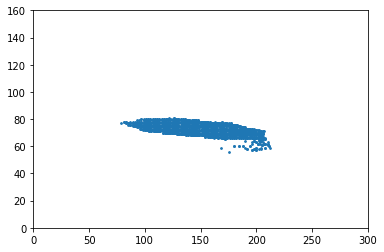

In [12]:
import matplotlib.pyplot as plt
plt.scatter(xtmp[:,30],ytmp[:,30],s=3)
plt.xlim([0,300])
plt.ylim([0,160])
plt.show()

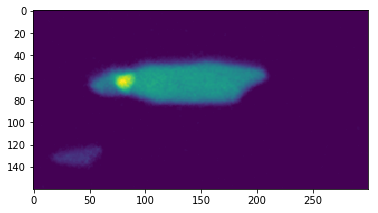

In [45]:
import matplotlib.pyplot as plt
ii=72

plt.imshow(np.sum(Im[ii][min(otmp[:,ii]):max(otmp[:,ii])+1],axis=0))
# plt.scatter(xtmp[:,ii],ytmp[:,ii],s=3)
plt.show()

In [48]:
np.where(otmp[:,ii]==5)

(array([1876]),)

In [50]:
ytmp[1876,ii]

53